In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('southparklines/All-seasons.csv')
questions = []
answers = []

In [3]:
for i in range(0, data.shape[0] - 1):
    if data.iloc[i + 1][2] == 'Stan':
        questions.append(data.iloc[i][3])
        answers.append(data.iloc[i + 1][3])

In [4]:
questions[0]

'Going away? For how long?\n'

In [5]:
answers[0]

'Forever.\n'

In [6]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [7]:
def preprocess_sentence(text):
    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"  ","",text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    text = text.strip()
    text = '<start> ' + text + ' <end>'
    return text

In [8]:
preprocess_sentence(questions[0])

'<start> going away for how long <end>'

In [9]:
preprocess_sentence(answers[0])

'<start> forever <end>'

In [10]:
clean_questions = []
clean_answers = []

for q in questions:
    clean_questions.append(preprocess_sentence(q))
for a in answers:
    clean_answers.append(preprocess_sentence(a))

In [11]:
max_length = 30
min_length = 1
short_questions_temp = []
short_answers_temp = []

i = 0
for question in clean_questions:
    if len(question.split()) >= min_length and len(question.split()) <= max_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])
    i += 1

# Filter out the answers that are too short/long
shorted_q = []
shorted_a = []

i = 0
for answer in short_answers_temp:
    if len(answer.split()) >= min_length and len(answer.split()) <= max_length:
        shorted_a.append(answer)
        shorted_q.append(short_questions_temp[i])
    i += 1

In [12]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer
def load_dataset(inp_lang, targ_lang):
  # creating cleaned input, output pairs
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [13]:
len(shorted_a)

6806

In [14]:
def load_dataset(inp_lang, targ_lang):
  # creating cleaned input, output pairs
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [15]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(shorted_q, shorted_a)

In [16]:
input_tensor.shape

(6806, 30)

In [17]:
target_tensor.shape

(6806, 30)

In [18]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

5444 5444 1362 1362


In [19]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [20]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
9 ----> that
5 ----> is
488 ----> true
114 ----> huh
119 ----> man
9 ----> that
364 ----> makes
34 ----> me
79 ----> really
5966 ----> reflect
24 ----> on
25 ----> my
948 ----> pet
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
11 ----> that
5 ----> is
342 ----> such
14 ----> a
201 ----> great
745 ----> paper
2 ----> <end>


In [21]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [22]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 30]), TensorShape([64, 30]))

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [24]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 30, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [26]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 30, 1)


In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [28]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4755)


In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [30]:
checkpoint_dir = './nmt_with_attention_southpark/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          
            loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

  
    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [32]:
EPOCHS = 91
loss_plt = []
for epoch in range(EPOCHS):
  
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print("Start save checkpoint in Epoch: ", epoch)
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
    if epoch%10 == 0:
        print("Start save checkpoint in Epoch: ", epoch)
        checkpoint.save(file_prefix = checkpoint_prefix)
    avloss = float(total_loss/steps_per_epoch)
    loss_plt.append(avloss)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Start save checkpoint in Epoch:  0
Epoch 1 Batch 0 Loss 2.2005
Start save checkpoint in Epoch:  0
Epoch 1 Loss 1.8569
Time taken for 1 epoch 46.637102365493774 sec

Start save checkpoint in Epoch:  1
Epoch 2 Batch 0 Loss 1.7103
Epoch 2 Loss 1.6074
Time taken for 1 epoch 14.074546813964844 sec

Start save checkpoint in Epoch:  2
Epoch 3 Batch 0 Loss 1.4485
Epoch 3 Loss 1.4899
Time taken for 1 epoch 14.546295166015625 sec

Start save checkpoint in Epoch:  3
Epoch 4 Batch 0 Loss 1.4257
Epoch 4 Loss 1.4203
Time taken for 1 epoch 14.370802164077759 sec

Start save checkpoint in Epoch:  4
Epoch 5 Batch 0 Loss 1.2157
Epoch 5 Loss 1.3639
Time taken for 1 epoch 13.999103307723999 sec

Start save checkpoint in Epoch:  5
Epoch 6 Batch 0 Loss 1.2384
Epoch 6 Loss 1.3110
Time taken for 1 epoch 13.992437839508057 sec

Start save checkpoint in Epoch:  6
Epoch 7 Batch 0 Loss 1.2188
Epoch 7 Loss 1.2605
Time taken for 1 epoch 13.981332063674927 sec

Start save checkpoint in Epoch:  7
Epoch 8 Batch 0 Loss

Start save checkpoint in Epoch:  60
Epoch 61 Loss 0.0175
Time taken for 1 epoch 14.542177200317383 sec

Start save checkpoint in Epoch:  61
Epoch 62 Batch 0 Loss 0.0114
Epoch 62 Loss 0.0168
Time taken for 1 epoch 13.974360942840576 sec

Start save checkpoint in Epoch:  62
Epoch 63 Batch 0 Loss 0.0130
Epoch 63 Loss 0.0166
Time taken for 1 epoch 13.978537321090698 sec

Start save checkpoint in Epoch:  63
Epoch 64 Batch 0 Loss 0.0210
Epoch 64 Loss 0.0163
Time taken for 1 epoch 13.90520977973938 sec

Start save checkpoint in Epoch:  64
Epoch 65 Batch 0 Loss 0.0133
Epoch 65 Loss 0.0163
Time taken for 1 epoch 13.965195894241333 sec

Start save checkpoint in Epoch:  65
Epoch 66 Batch 0 Loss 0.0065
Epoch 66 Loss 0.0171
Time taken for 1 epoch 13.910097122192383 sec

Start save checkpoint in Epoch:  66
Epoch 67 Batch 0 Loss 0.0085
Epoch 67 Loss 0.0166
Time taken for 1 epoch 13.923608303070068 sec

Start save checkpoint in Epoch:  67
Epoch 68 Batch 0 Loss 0.0199
Epoch 68 Loss 0.0168
Time taken fo

In [33]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [131]:
def translate(sentence):
    result, sentence, _ = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    return result[:-7]
  #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [132]:
results = translate("Hi Stan")

Input: <start> hi stan <end>
Predicted translation: you said we were going to be raggedy ann and andy remember <end> 


In [133]:
results

'you said we were going to be raggedy ann and andy remember'

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

30 30


In [36]:
translate("Hi Stan")

Input: <start> hi stan <end>
Predicted translation: you said we were going to be raggedy ann and andy remember <end> 


In [37]:
translate("Going Way")

Input: <start> going way <end>
Predicted translation: yeah let s go <end> 


In [38]:
translate("What are you doing here?")

Input: <start> what are you doing here <end>
Predicted translation: please ih ih it will not take long <end> 


In [39]:
translate("i was the vice president")

Input: <start> i was the vice president <end>
Predicted translation: i know <end> 


In [40]:
translate("i do not get it")

Input: <start> i do not get it <end>
Predicted translation: me neither <end> 


In [41]:
translate("stan")

Input: <start> stan <end>
Predicted translation: all right they finally came for us <end> 


In [42]:
translate("it just does not seem right")

Input: <start> it just does not seem right <end>
Predicted translation: yeah our eyes are finally open dude it is like waking up for the first time <end> 


In [43]:
translate("guys can i talk to you")

Input: <start> guys can i talk to you <end>
Predicted translation: sure dude <end> 


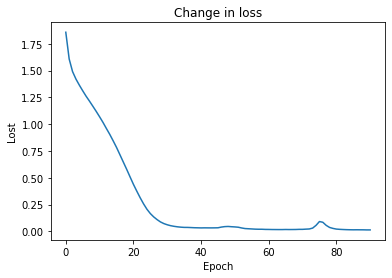

In [46]:
plt.plot(range(EPOCHS),loss_plt)
plt.title("Change in loss")
plt.xlabel('Epoch')
plt.ylabel('Lost')
plt.show()

In [104]:
questions = ['Hello!',
'How are you?',
'What’s your name?',
'When were you born?',
'Where are you from?',
'Are you a man or a woman?',
'Why are you here?',
'Okay bye!',
'See you later.',
'Happy birthday!',
'Have a nice day!',
'How old are you?',
'Would you like some tea?',
'What a nice day today!',
'How do you do?',
'Hey.',
'What’s up?',
'Good morning.',
'How are you doing?',
'Nice to meet you.',
'Thank you.',
'Where are you going?',
'Good luck!',
'Sounds good?',
'Talk to you later.',
'How can i help you?',
'I do not feel very well.',
'I miss you.',
'What are you going to do?',
'I do not understand.',
'Who is Bill clinton?',
'Is the sky blue or black?',
'Does a cat have a ear?',
'Can a cat fly?',
'How many legs does a cat have?',
'How many legs does a spider have?',
'What is the color of the sky?',
'What is the color of water?',
'How much is two plus two?',
'How much is ten add two?',
'What do you like to talk about?',
'What is your job?',
'Tell me something about you.',
'What do you think about coffee?\xa0',
'Do you like math?',
'Can you tell me a joke?',
'I really like the song. What do you think?',
'Do you like basketball?',
'What kind of music do you like best?',
'What’s your favorite sport?']

In [105]:
len(questions)

50

In [107]:
questions[26]

'I do not feel very well.'

In [134]:
answers = []

In [135]:
i = 0
for q in questions:
    print(i)
    answers.append(translate(q))
    i = i + 1

0
Input: <start> hello <end>
Predicted translation: help <end> 
1
Input: <start> how are you <end>
Predicted translation: i do not know i have to talk to the world then we have to talk to the world then we have to talk to the world then we have 
2
Input: <start> what s your name <end>
Predicted translation: you have to do <end> 
3
Input: <start> when were you born <end>
Predicted translation: dude you are here you know you you know you you know you you know you you know you you know you you know you you know you you know 
4
Input: <start> where are you from <end>
Predicted translation: we have to be that <end> 
5
Input: <start> are you a man or a woman <end>
Predicted translation: you meanyou <end> 
6
Input: <start> why are you here <end>
Predicted translation: i am done with you <end> 
7
Input: <start> okay bye <end>
Predicted translation: hello <end> 
8
Input: <start> see you later <end>
Predicted translation: wow this is this <end> 
9
Input: <start> happy birthday <end>
Predicted tr

In [139]:
import pandas as pd
d = {'questions': questions, 'answers': answers}
df = pd.DataFrame(data=d)

In [138]:
df.to_csv("south_park_results.csv", index=False, header=False)